# Coding Tutorial 2: Model Training and Evaluation

```
Course: CSCI 5922 Spring 2025, University of Colorado Boulder
TA: Everley Tseng
Email: Yu-Yun.Tseng@colorado.edu
* AI assistant is used in making this tutorial
```


## Overview

Sections:
- Dataset: generation and processing
- Model: building, training, and evaluation
- Training visualization
- Parameter initialization
- Optimization method

Objectives:
- Learn how to build, train, and evaluate a model
- Learn how to visualize the training process
- Learn how to initialize model parameters
- Learn how to optimize the model

In [1]:
import torch

## Data Processing

### Dataset Structure




To work with neural networks, we need to first understand what **problem** we are solving. That is because different problems could have very different dataset structures.

We'll be working on a **binary classification task** with the following structure:
- `x`: Inputs. Every example has 3 features $(X_1, X_2, X_3)$.
- `y`: Outputs. When $X_1 + X_2 + X_3 > 1.5$, $Y$ is positive; otherwise $Y$ is negative. This is the rule the model will be trying to learn.
- There are 1000 examples in this dataset.

Let's create this dataset using tensors:

In [2]:
num_samples = 1000
num_features = 3

x = torch.rand(num_samples, num_features) # Generate random x samples
y = (x[:, 0] + x[:, 1] + x[:, 2] > 1.5).float().unsqueeze(1)  # Binary labels
print('Input shape: {}. Output shape: {}'.format(x.shape, y.shape))

# See the first five samples
print("Input x:", x[:5])
print("Output y:", y[:5])

Input shape: torch.Size([1000, 3]). Output shape: torch.Size([1000, 1])
Input x: tensor([[0.2358, 0.1077, 0.0989],
        [0.0563, 0.6351, 0.1415],
        [0.6256, 0.1378, 0.8678],
        [0.9935, 0.8813, 0.7357],
        [0.2328, 0.1638, 0.0720]])
Output y: tensor([[0.],
        [0.],
        [1.],
        [1.],
        [0.]])


### Data Standardization

Normalize the x values

In [3]:
from torch.utils.data import TensorDataset, random_split

mean = x.mean(dim=0)
std = x.std(dim=0)
x_norm = (x - mean) / (std + 1e-8)
print(x_norm.shape)

torch.Size([1000, 3])


### Split Data


Next, we need to split the data into `train` and `test` sets. We're going to divide our 100 samples using the following proportions:
- train (80\%): for training the model
- test (20\%): for evaluating the model performance

We can create a random split using the `torch` function  `torch.utils.data.random_split`, discussed [here](https://pytorch.org/docs/stable/data.html).

In [4]:
x_train = x_norm[:int(len(x)*0.8)].cuda()
y_train = y[:int(len(x)*0.8)].cuda()

x_test = x_norm[int(len(x)*0.8):].cuda()
y_test = y[int(len(x)*0.8):].cuda()

print('Training input size: {}, output size: {}'.format(x_train.shape, y_train.shape))
print('Testing input size: {}, output size: {}'.format(x_test.shape, y_test.shape))

Training input size: torch.Size([800, 3]), output size: torch.Size([800, 1])
Testing input size: torch.Size([200, 3]), output size: torch.Size([200, 1])


We will now build and train a **binary classification model** to address our binary classification task.

## Model Structure and Training



There are three key components for building a model in PyTorch.

- **Model**: This is where you define the structure of your neural network, including its layers and how data flows through them. [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) is the base class for all neural network modules.
- **Layer**: Use the [index](https://pytorch.org/docs/stable/nn.html) in `torch.nn` to explore many types of layers that will be covered in this course (e.g., linear layers, convolution layers, recurrent layers, transformer layers)
- **Activation function**: Explore the [non-linear activations](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) available in `torch.nn`.

### Define Model Architecture

When we build a model using `nn.Module`, there are two key decisions:
- What are the layers in a model?
- How are the layers connected?

For this `MLPBinaryClassifier` model, let's use the following design:
- 3 fully-connected layers (with flexible hidden layer size)
- [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) as the activation function
- Output as binary classification (from 0 to 1)


In [5]:
import torch.nn as nn

class MLPBinaryClassifier(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(MLPBinaryClassifier, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size

    # Define all layers in the model
    # layer 1
    self.linear1 = nn.Linear(self.input_size, hidden_size)
    self.activation1 = nn.Sigmoid()
    # layer 2
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.activation2 = nn.Sigmoid()
    # layer 3
    self.linear3 = nn.Linear(hidden_size, 1)
    # sigmoid keeps the output value between 0 and 1
    self.activation3 = nn.Sigmoid()

  def forward(self, x):
    # Build the feed forward structure
    linear1 = self.linear1(x)
    act1 = self.activation1(linear1)
    linear2 = self.linear2(act1)
    act2 = self.activation2(linear2)
    linear3 = self.linear3(act2)
    output = self.activation3(linear3)
    return output


#### Model Summary

Let's now visualize the model structure and observe its **number of parameters** with `torchsummary.summary`. We will assume all hidden layers have $16$ nodes and the input data size is $3$:

In [6]:
from torchsummary import summary

# Create the model
hidden_size = 16
model = MLPBinaryClassifier(input_size=num_features, hidden_size=hidden_size).cuda()

# Print model summary
summary(model, input_size=(1,3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 16]              64
           Sigmoid-2                [-1, 1, 16]               0
            Linear-3                [-1, 1, 16]             272
           Sigmoid-4                [-1, 1, 16]               0
            Linear-5                 [-1, 1, 1]              17
           Sigmoid-6                 [-1, 1, 1]               0
Total params: 353
Trainable params: 353
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


Let's do some quick math here to verify the calculated parameters in the listed layers in this architecture. Given the linear layer formula,
$y = xW + b$:

**Linear-1**:

- Weights: The shape of $x$ (layer input) is $(1, 3)$, and the shape of $y$ (layer output) is $(1, 16)$, so the shape of the weights $W$ should be $(3, 16)$, which leads to $3 \times 16 = 48$ parameters.
- Biases: The shape of the biases $b$ should resemble the shape of $y$ (layer output), which is $(1, 16)$. This leads to $1 \times 16 = 16$ parameters.

In total, there are $48 + 16 = 64$ parameters in this layer.


**Sigmoid-2**:

The activation layer, sigmoid, doesn't have parameters. Therefore, there are $0$ parameters and the output remains the same shape as input.


**Practices**:

Now, using the above techniques, can you calculate the parameters in the rest of the layers?
- Why does `Linear-3` have $272$ parameters?
- Why does `Linear-5` have $17$ parameters?

#### Model Architecture Graph Visualization

`torchviz` is a Python library used for visualizing the computational graph of PyTorch models. It generates a graphical representation of the operations (like tensor transformations and layers) performed during the forward pass of a neural network, and then you can see how data flows through the layers and operations.  The function `make_dot` is typically used to create the graph. It takes the output of a PyTorch model (the result of a forward pass) and visualizes the flow of tensors through the network. To do so, we need to pass in the [`nn.Module.named_parameters`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.named_parameters).

**Colab Installation**

If you need a library that is not pre-installed by Colab, use use the `!pip install` command to install it.

In [7]:
!pip install torchviz

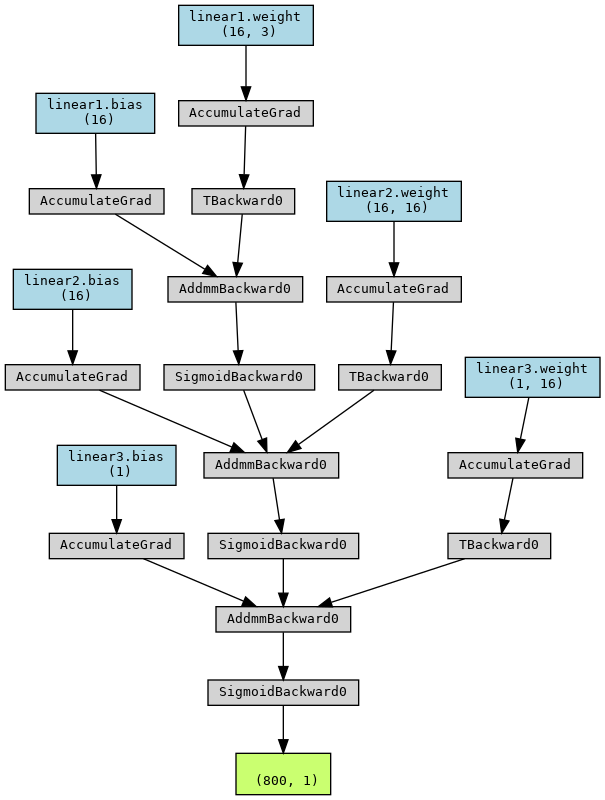

In [8]:
from torchviz import make_dot

model = MLPBinaryClassifier(input_size=num_features, hidden_size=hidden_size).cuda()
y_pred = model(x_train) # Pass in training set

dot = make_dot(y_pred, params=dict(model.named_parameters()))  # Generate the graph
dot.render("model_graph", format="png")  # Save the graph as a PNG file

from IPython.display import Image
Image(filename="model_graph.png")

### Train the Model

To train the model, we need to define the following components in `torch`:
- **Optimizer**: The optimizer is responsible for updating the model's parameters based on the gradients calculated during training. Choose one from the [optimizers index](https://pytorch.org/docs/stable/optim.html#algorithms) and review the documentation for how to use the chosen optimizer. For instance, the [SGD optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) requires as input the model parameters (`params`), and lets users override default values such as the learning rate `lr` (e.g., `lr=0.001`).
  - What is `optimizer.zero_grad()`?  [torch.optim.Optimizer.zero_grad](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html)
- **Loss function**: The loss function measures the error (i.e., difference between the model's predictions and the actual target values). During training, the optimizer works to **minimize this error**. Check out the available loss functions in the [loss functions index](https://pytorch.org/docs/stable/nn.html#loss-functions).
- **Evaluation metric**: The evaluation metric(s) is optional. It does **not** impact the feedforward and back-propagating steps. However, we typically evaluate the model periodically during training (e.g., every $n$ epochs). To define the metric, you can implement your own code or use existing libraries.
  - [`torchmetrics`](https://lightning.ai/docs/torchmetrics/stable/): This library includes implemented metrics and provides a module for defining your own metric. It works well with PyTorch’s `torch.nn.Module` and can be used directly with models.
  - [`sklearn.metrics`](https://scikit-learn.org/1.5/api/sklearn.metrics.html): This library includes a collection of common metrics and is easy to use for quick evaluations outside of model training loops. It works with NumPy arrays (`numpy`) or Pandas DataFrames (`pandas`).


In [9]:
!pip install torchmetrics

Let's practice training this MLP binary classification model with the following settings:
- Use SGD Optimizer: read the [documentation](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) before using
- Use the Binary Cross Entropy Loss: read the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) before using
- Use the metric, **accuracy**, to evaluate the model. Install and import `torchmetrics` library, and use `torchmetrics.classification.BinaryAccuracy`: read the [documentation](https://lightning.ai/docs/torchmetrics/stable/classification/accuracy.html#binaryaccuracy) before using.

In [10]:
import torch.optim as optim
import torchmetrics

hidden_size = 16
model = MLPBinaryClassifier(input_size=num_features, hidden_size=hidden_size).cuda()

# Define loss function and optimizer
loss_function = nn.BCELoss()

# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Define evaluation metric
accuracy_metric = torchmetrics.classification.BinaryAccuracy().cuda()

# Start training
num_epochs = 1000
epochs = [] # x axis for history
losses = [] # loss history
accuracies = [] # acc history
for epoch in range(num_epochs):

    # feedforward
    predictions = model(x_train) # acquire output value (prediction)
    loss = loss_function(predictions, y_train) # calculate error between prediction and ground truth

    # gradient descent
    optimizer.zero_grad()
    loss.backward() # backpropagation
    optimizer.step() # update parameters

    # Compute loss and accuracy for the epoch
    epoch_loss = loss.item()
    epoch_accuracy = accuracy_metric(predictions, y_train)

    # print loss and accuracy every n (=20) epochs
    if epoch % 100 == 99:
        print('Epoch {}/{}, loss: {:.4f}, acc train (%): {:.2f}'.format(epoch+1, num_epochs, epoch_loss, epoch_accuracy*100))

    # Save loss and accuracy
    epochs.append(epoch)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

Epoch 100/1000, loss: 0.6867, acc train (%): 51.00
Epoch 200/1000, loss: 0.6748, acc train (%): 71.00
Epoch 300/1000, loss: 0.6496, acc train (%): 85.88
Epoch 400/1000, loss: 0.5912, acc train (%): 95.25
Epoch 500/1000, loss: 0.4757, acc train (%): 97.25
Epoch 600/1000, loss: 0.3387, acc train (%): 98.62
Epoch 700/1000, loss: 0.2419, acc train (%): 99.25
Epoch 800/1000, loss: 0.1848, acc train (%): 99.50
Epoch 900/1000, loss: 0.1499, acc train (%): 99.62
Epoch 1000/1000, loss: 0.1269, acc train (%): 99.62


## Model Evaluation



When we see the loss dropping, we know that the training is converging! However, the model is only converging on the `train` set. For a standard model evaluation, need to evaluate the trained model on the `test` set.

- Ensure the model is in evaluation mode with `model.eval()`

Let's see this model's performance on the test set:

In [11]:
model.eval() # evaluation mode
y_pred = model(x_test) # pass test input into the trained model
test_accuracy = accuracy_metric(y_pred, y_test)

print('Test set score (accuracy in %): {}'.format(test_accuracy*100))

Test set score (accuracy in %): 98.5


## Training Visualization

### Loss Curve

A standard training monitoring method is to **plot the learning curve**. In theory, loss will drop over training epochs, and we could observe that through the printed information. However, a more intuitive approach is to visualize those values with a curve. In this section, we will learn to implement the loss plot using the library, `matplotlib`.

 **Matplotlib**

Matplotlib is a widely used Python library for visualization. It can be used to generate a variety of plots, such as line charts, scatter plots, histograms, and more. In deep learning, Matplotlib is particularly useful for plotting and visualizing data to monitor and analyze the performance of your models during training and evaluation. A common way to load the package is:
```
import matplotlib.pyplot as plt
```
In this tutorial, we will be using the `plt.plot()` function to plot lines on a figure. There are more visualization methods to explore in the [Matplotlib library](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html).

**External Resources**

- What's matplotlib? [GeeksforGeeks: Introduction to Matplotlib](https://www.geeksforgeeks.org/python-introduction-matplotlib/)
- Call the function `matplotlib.pyplot.plot()`: [visualize lines](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html)
- To use matplotlib locally (not on Colab), install the package following the instructions on [this page](https://matplotlib.org/stable/install/index.html).

Below are the practice toward visualizing a plot in your notebook using the library.

1. Create a figure. First, assign the size:
```
plt.figure(figsize=(6, 3))
```
2. Make the plot. For instance, we will be using `plt.plot()` for plotting a line. You can plot multiple lines to a figure. The styles and colors can be specified in the function.
```
plt.plot(x_values, y_values)
```
3. Define title, axis label, and legend for the figure.
```
plt.title('title')
plt.xlabel('x label')
plt.ylabel('y label')
plt.legend()
```
4. Next, visualize the figure. If you'd like to save the figure to your local directory, save it before `plt.show()`. Calling `plt.show()` will trigger showing the figure in the notebook and emptying the canvas.
```
plt.savefig(save_path)
plt.show()
```

Now, let's code! Following the above steps, we can build this function for plotting a **loss curve**. The input `epochs` will be the x values, and the input `losses` will be the y values.

In [12]:
import matplotlib.pyplot as plt

def loss_plot(epochs, losses_list, loss_names):
  plt.figure(figsize=(6, 3))
  for losses, loss_name in zip(losses_list, loss_names):
    plt.plot(epochs, losses, label=loss_name)
  plt.title('Loss Plot')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

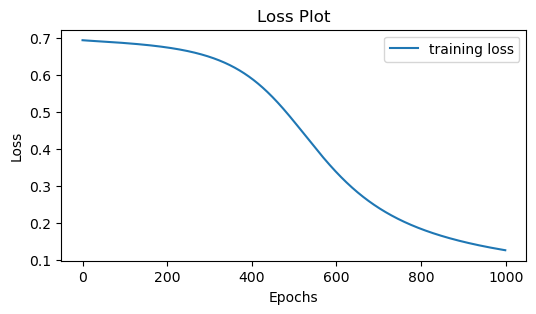

In [13]:
losses_list = [losses]
loss_names = ['training loss']
loss_plot(epochs, losses_list, loss_names)

### Parameters and Features Visualization [Helper Function for Tutorial]

On top of learning curves, we are also able to visualize the distributions of model parameters and features in intermediate layers. Below is code of a helper class for visualizing feature and gradient distributions. This is intended purely for educational purposes; **this code is not needed for regular model training** but we think its valuable for learning purposes in this tutorial.  The following are links about the libraries used:
- [`numpy`](https://numpy.org/doc/2.2/user/quickstart.html)
- [`seaborn.violinplot`](https://seaborn.pydata.org/generated/seaborn.violinplot.html)
- [`pd.DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)



In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class Visualization_Helper():
    def __init__(self):
        self.columns = ['epoch', 'layer', 'value']
        self.gradients = pd.DataFrame(columns=self.columns)
        self.parameters = pd.DataFrame(columns=self.columns)
        self.z_values = pd.DataFrame(columns=self.columns)
        self.activations = pd.DataFrame(columns=self.columns)

    def update_values(self, model, epoch):
        for name, param in model.named_parameters():
            gradients = pd.DataFrame([[epoch, name, g] for g in param.grad.cpu().numpy().ravel() if 'weight' in name], columns=self.columns)
            parameters = pd.DataFrame([[epoch, name, g] for g in param.data.cpu().numpy().ravel() if 'weight' in name], columns=self.columns)
            self.gradients = pd.concat([self.gradients, gradients], ignore_index=True)
            self.parameters = pd.concat([self.parameters, parameters], ignore_index=True)
        for name, values in model.z_values.items():
            z_values = pd.DataFrame([[epoch, name, v] for v in values.detach().cpu().numpy().ravel()], columns=self.columns)
            self.z_values = pd.concat([self.z_values, z_values], ignore_index=True)
        for name, values in model.activations.items():
            activations = pd.DataFrame([[epoch, name, v] for v in values.detach().cpu().numpy().ravel()], columns=self.columns)
            self.activations = pd.concat([self.activations, activations], ignore_index=True)

    def plot(self, figsize=(11 ,3)):
        plot_names = ['Gradient', 'Model Parameters', 'Z Values', 'Activations']
        plot_datas = [self.gradients, self.parameters, self.z_values, self.activations]
        for name, data in zip(plot_names, plot_datas):
            plt.figure(figsize=figsize)
            sns.violinplot(data=data, x='layer', y='value', hue='epoch')
            plt.title(name)
            plt.show()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Parameter Initialization


In the vanilla MLP model class `MLPBinaryClassifier`, we didn't specify the initialization method for model parameters. This means that when a model is created, the parameters will be initialized using the default method. For instance, the linear layer [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) indicates the default initialization method in the **Variables** section.

To define your own initialization for a layer, you can use the module `nn.init`. For example, for a uniform distribution:
```
nn.init.uniform_(self.linear1.weight, a=a, b=b)
```

To explore different builtin initialization options, see the [index](https://pytorch.org/docs/stable/nn.init.html#).

- Below, we copy the vanilla model and add flexibility to the initialization range with a uniform distribution.
- We will now apply the visualization helper class to visualize the features and gradient values flowing through a model.  To do so, we create `self.z_values` and `self.activations` to store these values, by accumulating the weighted sums and activations of the hidden layers.


In [15]:
class MLPBinaryClassifierInit(nn.Module):
  def __init__(self, input_size, hidden_size, init_value=None):
    super(MLPBinaryClassifierInit, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size

    # Define all layers in the model
    self.linear1 = nn.Linear(self.input_size, hidden_size)
    self.activation1 = nn.Sigmoid()
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.activation2 = nn.Sigmoid()
    self.linear3 = nn.Linear(hidden_size, 1)
    self.activation3 = nn.Sigmoid()

    # Define features
    self.z_values = {}
    self.activations = {}

    # parameter initialization
    if init_value is not None:
      nn.init.uniform_(self.linear1.weight, a=init_value[0], b=init_value[1])
      nn.init.uniform_(self.linear1.bias, a=init_value[0], b=init_value[1])
      nn.init.uniform_(self.linear2.weight, a=init_value[0], b=init_value[1])
      nn.init.uniform_(self.linear2.bias, a=init_value[0], b=init_value[1])
      nn.init.uniform_(self.linear3.weight, a=init_value[0], b=init_value[1])
      nn.init.uniform_(self.linear3.bias, a=init_value[0], b=init_value[1])

  def forward(self, x):
    # Build the feed forward structure
    linear1 = self.linear1(x)
    act1 = self.activation1(linear1)
    linear2 = self.linear2(act1)
    act2 = self.activation2(linear2)
    linear3 = self.linear3(act2)
    output = self.activation3(linear3)

    # Update features for visualization purpose
    self.z_values = {'linear1':linear1, 'linear2':linear2}
    self.activations = {'act1':act1, 'output':output}

    return output


To save the coding effort for model training, we'll use the following function `training_and_visualization` designed to train and visualize a model. In the following subsections, we'll be testing different initialization settings.

In [16]:
def training_and_visualization(model, n_epochs=10, vis_n_epochs=30):
    loss_func = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=2e-1)
    visualization = Visualization_Helper()

    losses = []
    epochs = []
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = loss_func(y_pred, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        epochs.append(epoch+1)
        visualization.update_values(model, epoch)
    visualization.plot()

### Default Initialization



When using the default initialization, we can see the following trends:
- Gradient: Converging as moving through epochs. This aligns with what we learn in lectures about gradient descent, local minimum, and global minimum. Through this visualization, we can see if the gradient is trending in a healthy way.
- Parameters: Starting from the randomized distribution, the parameters gradually converge to what is needed to perform the trained task.
- Z values and activations: Similar to the parameters, the feature distributions are formed toward what is needed for the trained task.

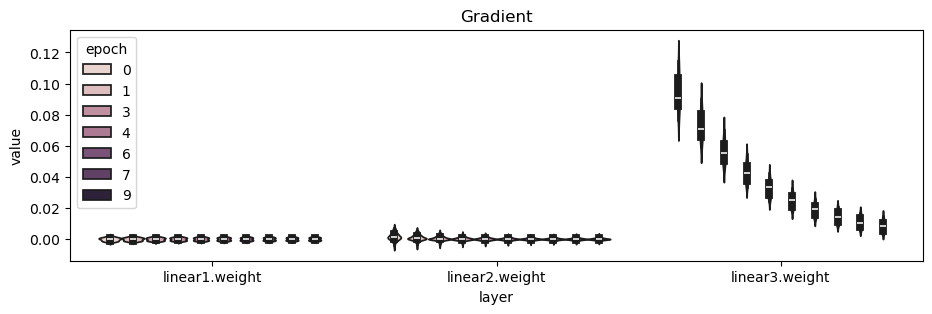

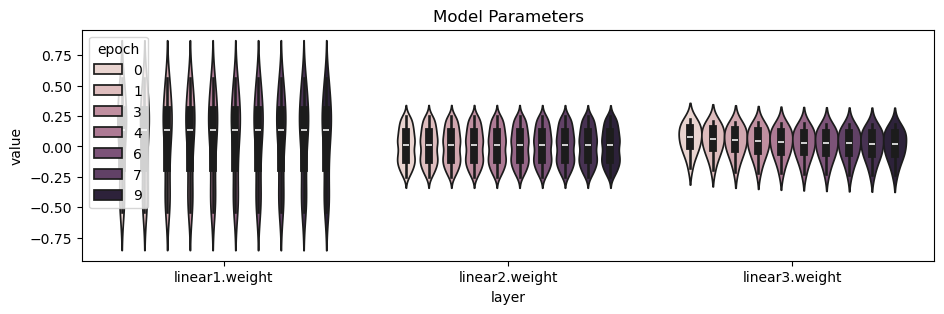

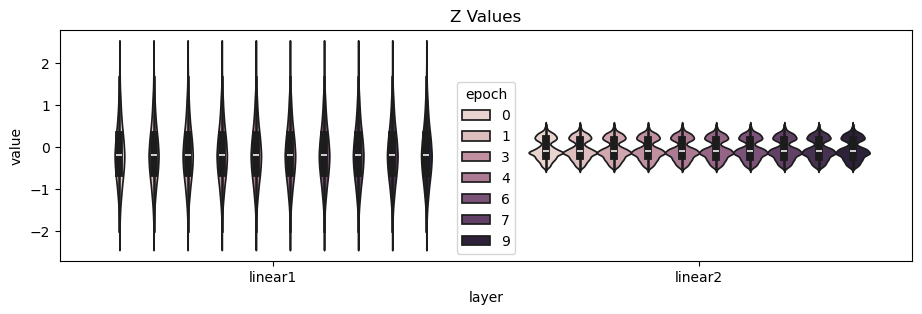

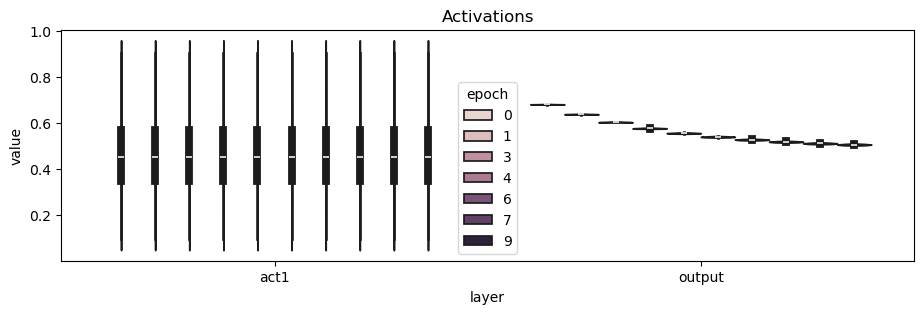

In [17]:
init_value = None # default

model = MLPBinaryClassifierInit(input_size=num_features, hidden_size=hidden_size, init_value=init_value).cuda()
training_and_visualization(model)

### Zero Initialization



When using the default initialization, all of the visualized values are **zeros** (except for the activation values). Why is that?

1. When the parameters in $W$ and $b$ are all zeros, all the z values ($y$) calculated by the linear function $y = xW + b$ will be zeros.
2. If all the z values are zeros, the activation outputs will be fixed values (e.g., for sigmoid function, the output is $0.5$ if the input is $0$).
3. By performing backpropagation on these zero layers, we get the derivatives as zeros as well.

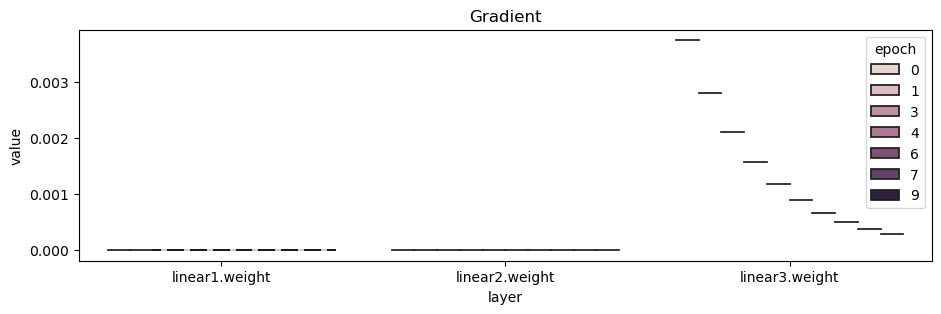

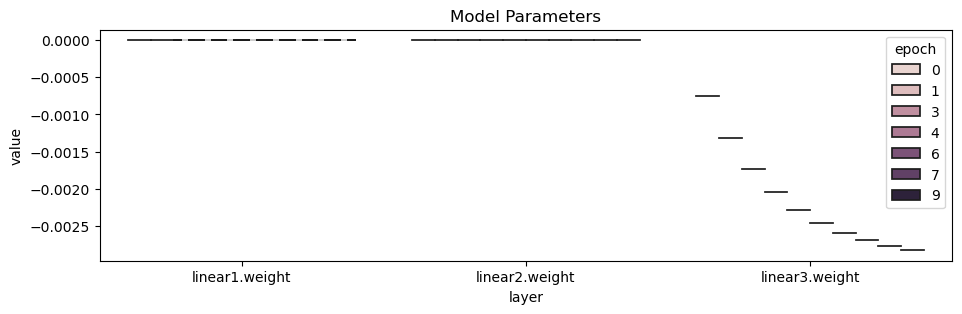

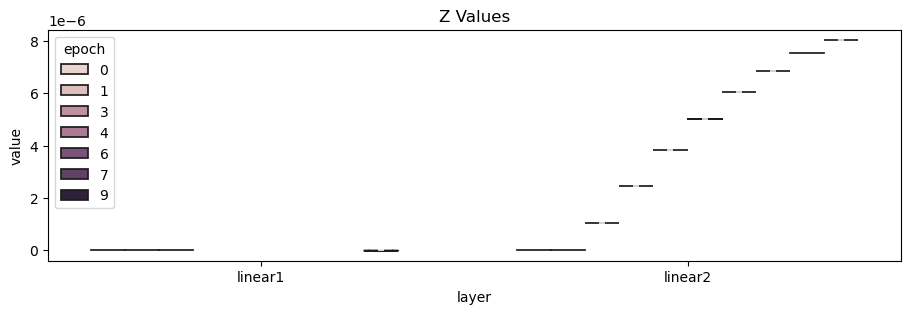

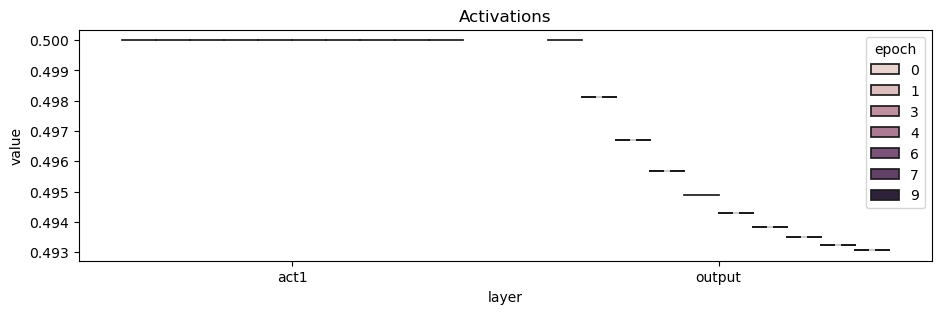

In [18]:
init_value = (0,0) # zero initialization

model = MLPBinaryClassifierInit(input_size=num_features, hidden_size=hidden_size, init_value=init_value).cuda()
training_and_visualization(model)

### Large Initialization




What if we initialize all the parameters with **very large values**?

For activation functions like Sigmoid and Tanh, the derivatives (gradients) become very small when the input z is far from 0. See the next cell for the function figures. This is the **vanishing gradients** we learned about in the lecture.

As a a reminder, we show below the plots for the `sigmoid` and `tanh` functions.


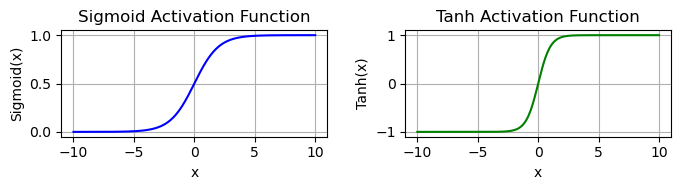

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

x = np.linspace(-10, 10, 400)
sigmoid_values = sigmoid(x)
tanh_values = tanh(x)
fig, axs = plt.subplots(1, 2, figsize=(7, 2))

axs[0].plot(x, sigmoid_values, label="Sigmoid", color='blue')
axs[0].set_title("Sigmoid Activation Function")
axs[0].set_xlabel("x")
axs[0].set_ylabel("Sigmoid(x)")
axs[0].grid(True)

axs[1].plot(x, tanh_values, label="Tanh", color='green')
axs[1].set_title("Tanh Activation Function")
axs[1].set_xlabel("x")
axs[1].set_ylabel("Tanh(x)")
axs[1].grid(True)

plt.tight_layout()
plt.show()

These are the distributions that we see when very large values are used to initialize the parameters:
1. The z values tend to be very large due to the large parameters.
2. From the sigmoid plot in the above cell, we see when the input (z values) are large the activation outputs tend to be close to **ones**.
3. This leads to vanishing gradients, where we see the distributions of gradients being almost all zeros.
4. Without gradients, the parameters barely change throughout the epochs.

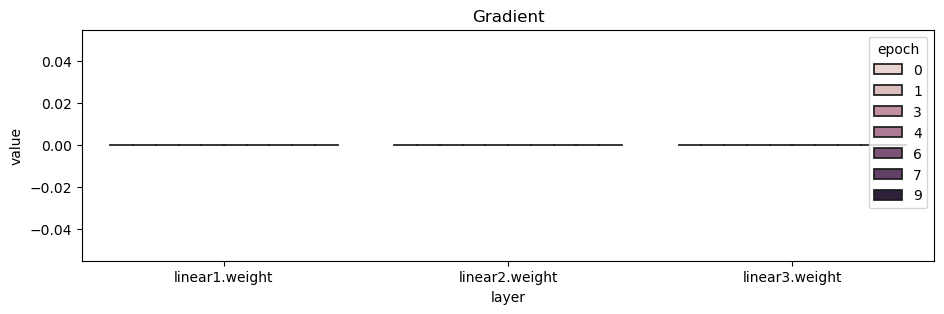

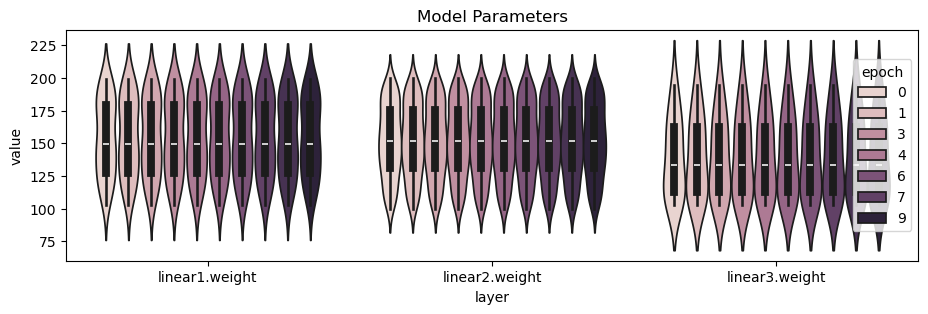

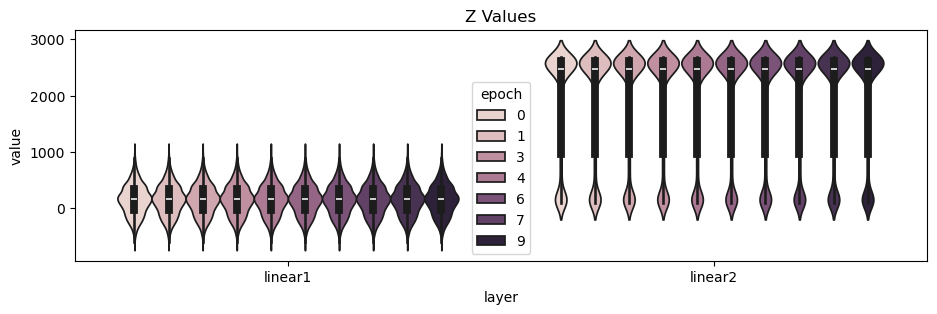

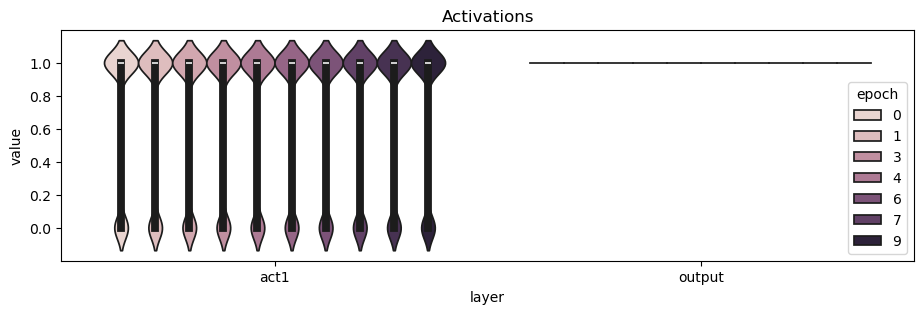

In [20]:
init_value = (100, 200) # large initialization

model = MLPBinaryClassifierInit(input_size=num_features, hidden_size=hidden_size, init_value=init_value).cuda()
training_and_visualization(model)

### Glorot Initialization

We will now compare the **loss curves** of the **default** parameter initialization and the **Glorot/Xavier** initialization. For Glorot initialization, we will create a new model class `MLPBinaryClassifierGlorot` and add the initialization method `nn.init.xavier_uniform_` to the layers.

In [21]:
class MLPBinaryClassifierGlorot(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(MLPBinaryClassifierGlorot, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size

    self.linear1 = nn.Linear(self.input_size, hidden_size)
    self.activation1 = nn.Sigmoid()
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.activation2 = nn.Sigmoid()
    self.linear3 = nn.Linear(hidden_size, 1)
    self.activation3 = nn.Sigmoid()

    # Use glorot/xavier initialization for every layer
    nn.init.xavier_uniform_(self.linear1.weight)
    nn.init.zeros_(self.linear1.bias)
    nn.init.xavier_uniform_(self.linear2.weight)
    nn.init.zeros_(self.linear2.bias)
    nn.init.xavier_uniform_(self.linear3.weight)
    nn.init.zeros_(self.linear3.bias)

  def forward(self, x):
    linear1 = self.linear1(x)
    act1 = self.activation1(linear1)
    linear2 = self.linear2(act1)
    act2 = self.activation2(linear2)
    linear3 = self.linear3(act2)
    output = self.activation3(linear3)
    return output


We will again create a simple training function to facilitate loss visualization. Return the history, `losses`, from training.

In [22]:
def training_and_return_losses(model, optimizer, n_epochs):
  loss_function = nn.BCELoss()
  accuracy_metric = torchmetrics.classification.BinaryAccuracy().cuda()
  epochs = []
  losses = []
  for epoch in range(n_epochs):
      predictions = model(x_train)
      loss = loss_function(predictions, y_train)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_loss = loss.item()
      epoch_accuracy = accuracy_metric(predictions, y_train)
      epochs.append(epoch)
      losses.append(epoch_loss)
  return epochs, losses

Using the `loss_plot` function, we can plot and compare the loss curves. What do you observe from the curves?

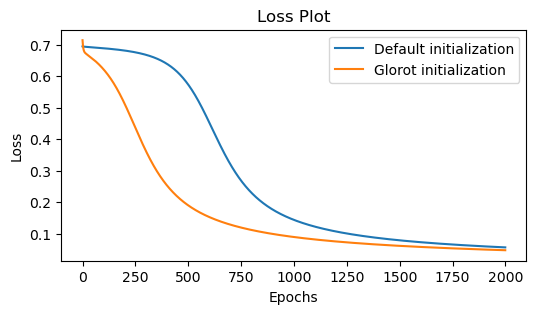

In [23]:
hidden_size = 16
n_epochs = 2000

# Train a model with default initialization
model_default = MLPBinaryClassifier(input_size=num_features, hidden_size=hidden_size).cuda()
optimizer = optim.SGD(model_default.parameters(), lr=0.1)
epochs, default_losses = training_and_return_losses(model_default, optimizer, n_epochs)

# Train a model with Glorot initialization
model_glorot = MLPBinaryClassifierGlorot(input_size=num_features, hidden_size=hidden_size).cuda()
optimizer = optim.SGD(model_glorot.parameters(), lr=0.1)
epochs, glorot_losses = training_and_return_losses(model_glorot, optimizer, n_epochs)

loss_plot(epochs, [default_losses, glorot_losses], ['Default initialization', 'Glorot initialization'])

## Optimization: Stochastic Gradient Descent (SGD) with Momentum

In this last experiment, we will compare the loss curves with different setups of the `optimizer`. Compare the curves of the **vanilla SGD optimizer** to the SGD optimizer with **momentum as 0.9**.

You can see the significant improvement in the convergence time. The model using SGD optimizer **with momentum** converged within 500 epochs, while the model using vanilla SGD needs a lot more epochs to converge.

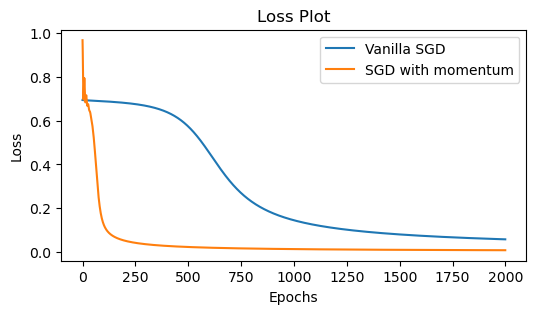

In [24]:
# Train a model with default initialization but add momentum to the SGD optimizer
model_default = MLPBinaryClassifierGlorot(input_size=num_features, hidden_size=hidden_size).cuda()

# Specify momentum value (0.9)
optimizer_momemtum = optim.SGD(model_default.parameters(), lr=0.1, momentum=0.9)
epochs, momentum_losses = training_and_return_losses(model_default, optimizer_momemtum, n_epochs)

loss_plot(epochs, [default_losses, momentum_losses], ['Vanilla SGD', 'SGD with momentum'])

## Deep Learning Frameworks

While we are focusing on PyTorch for this course, it is beneficial for you to learn about different deep learning frameworks. Understanding the strengths and limitations of various frameworks can help you **choose the best tool** for specific tasks in your future projects.  So, let's take a closer look at some of the most popular deep learning frameworks.


#### PyTorch

As introduced in the previous tutorial, PyTorch is **one of the** widely-used frameworks, especially favored by researchers and developers for its **flexibility** and Pythonic design.

#### Tensorflow & Keras
One of PyTorch’s main competitors is TensorFlow, an open-source library developed by Google. TensorFlow is renowned for its **scalability** and production-ready features. It also integrates the high-level **Keras API**, which simplifies the process of building and training models for beginners and rapid prototyping. Additionally, it provides **TensorBoard**, which integrates seamlessly with TensorFlow, to allow users to easily visualize model architectures, training metrics, and loss curves.

#### JAX
JAX provides advanced numerical computing and differentiation. Developed by Google, JAX specializes in **automatic differentiation and functional programming**, making it a popular choice for researchers exploring custom model implementations or experimental algorithms.


### External Resources

- Learn about more deep learning frameworks [here](https://en.wikipedia.org/wiki/Comparison_of_deep_learning_software)
- 7 Best Deep Learning Frameworks You Should Know in 2025 ([Geeks4geeks](https://www.geeksforgeeks.org/deep-learning-frameworks/))
- Deep Learning Frameworks (by [NVIDIA](https://developer.nvidia.com/deep-learning-frameworks))

## Review

It is common to feel overwhelmed by all the steps if this is your first time using PyTorch to train a model. Let's review all the steps below and get familiar with this library!

**[Dataset]**
- Generate a dataset with `x` (input) and `y` (output)
- Split your dataset into `train` and `test` sets.

**[Model Structure]**
- Build the model from the base class `nn.Module`
- In the model class, define layers including linear layers such as `nn.Linear` and activation layers such as `nn.Sigmoid`
- In the model's `forward` function, define the feed-forward mechanism by passing the tensor from layer to layer

**[Training]**
- Use an evaluation metric such as `torchmetrics.classification.BinaryAccuracy` to evaluate the model performace
- Select an optimizer such as `optim.SGD` and set up proper hyperparameters
- Select a loss function such as `nn.BCELoss()` for training
- Pass the input into the model such as `predictions = model(x_train)`
- Calculate the loss between prediction and ground truth such as `loss = loss_function(predictions, y_train)`

**[Evaluation]**
- To evaluate the model, set `model.eval()` and `torch.no_grad()`
- Pass the test set into the model for prediction such as `y_pred = model(x_test)`
- Acquire the score by applying the defined metric

**[Visualization]**
- To visualize the curves, use `matplotlib.pyplot.plot()`

You can try the following practices:
1. Create a new dataset with a different setup. For instance,
```
num_samples = 500
num_features = 2
x = torch.rand(num_samples, num_features) # Generate random x samples
y = (x[:,0] > 0.5).float().unsqueeze(1)  # Binary labels
```

2. Build a binary classification model with 5 linear layers and `hidden_size=128`
3. Train this new model with your new dataset and plot the curves. Does the model converge?
4. Tweak the settings for initialization and optimization. What setup would facilitate the model to converge faster?

For any questions and discussions regarding this tutorial, attend [TA office hours](https://docs.google.com/spreadsheets/d/1fzfTJpEF7RaUYRA_NGa3DkiazdQXVj7QNBbp6DrEZ3I/edit?usp=sharing) or create a post on [Piazza](https://piazza.com/colorado/spring2025/csci5922/home) :)

\- Everley